<font color=gray>Oracle Cloud Infrastructure Data Science Demo Notebook

Copyright (c) 2021 Oracle, Inc.<br>
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font> Predicting Employee Attrition with ADS</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> OCI Data Science PM Team </font></p>

***

## Overview:

In this notebook, we will be using an employee attrition dataset. We will start by doing an exploratory data analysis (EDA) to understand the data. Then a model will be trained using `scikit-learn`. The model will be used to make predictions and evaluate the model to determine how well it generalizes to new data. You will prepare and save the resulting model to the model catalog using Oracle's Accelerated Data Science, (`ADS`) library.

Let's do all of the imports necessary to get this notebook working up here.

**<font color='red'>NOTE: This notebook was run in the TensorFlow 2.7 for CPU (slug: `tensorflow27_p37_cpu_v1`) conda environment with ADS version 2.5.10. Upgrade your version of ADS (see cell below) and restart your kernel.</font>**

In [1]:
# !pip install oracle-ads==2.5.10
!pip install onnxconverter-common --upgrade

In [2]:
import io
import warnings
import logging
import os
from os import path 
from os.path import expanduser
from os.path import join

from category_encoders.ordinal import OrdinalEncoder
from collections import defaultdict

from ads.common.model import ADSModel
from ads.dataset.factory import DatasetFactory
from ads.evaluations.evaluator import ADSEvaluator

import pandas as pd

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import get_scorer
import numpy as np 

import ads 
ads.set_auth(auth='resource_principal') 

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

## Open and Visualize the Attrition Dataset using `ADS`

<a id='binaryclassifition'></a>
### Binary Classification

Binary classification is a technique of classifying observations into one of two groups. In this notebook, the two groups are those employees that will leave the organization and those that will not. 

Given the features in the data, the model will determine the optimal criteria for classifying an observation as leaving or not leaving. This optimization is based on the training data. However, we will holdout some of the data to test the model's preformance. Models can over-fit on the training data, that is learn the noise in a dataset and then it will not do a good job at predicting the results on new data (test data). Since we already know the truth for the data in the training dataset, we are really interested in how well it performs on the test data.

<a id='data'></a>
### The Dataset

This is a fictional data set which contains 1,470 rows. There are 36 features. 22 features are ordinal, 11 are categorical, and 3 are constant values. The features include basic demographic information, compensation level, job characteristics, job satisfaction and employee performance metrics. The data is not balanced as fewer employees leave than stay.

The first step is to load in the dataset. To do this the `DatasetFactory` singleton object will be used. It is part of the `ADS` library. It is a powerful class to work with datasets from different sources.

<font color=gray>Datasets are provided as a convenience.  Datasets are considered Third Party Content and are not considered Materials under Your agreement with Oracle applicable to the Services.  You can access the `orcl_attrition` dataset license [here](oracle_data/UPL.txt). Dataset `orcl_attrition` is distributed under UPL license. 
</font>

In [3]:
# ADS version used in this notebook: 
print(ads.__version__)

2.5.0


The code cell below will work only if your notebook session is running in the **Ashburn** region. If not use these instructions to download it to your local computer, then upload it to the notebook session, then use it to create a dataset. 

1. Download the file from this public url and save it on your local computer: 
https://objectstorage.us-ashburn-1.oraclecloud.com/n/bigdatadatasciencelarge/b/hosted-ds-datasets/o/synthetic%2Forcl_attrition.csv

2. Use the Upload Files button (or drag and drop) to upload the csv file to the same folder as 1-model-training.ipynb

3. Run the following instruction instead of the code cell below.
```
employees = DatasetFactory.open("synthetic_orcl_attrition.csv", format='csv', delimiter=",", target="Attrition").set_positive_class('Yes')
```

In [4]:
bucket_name = "hosted-ds-datasets"
namespace = "bigdatadatasciencelarge"
employees = DatasetFactory.open(
        "oci://{}@{}/synthetic/orcl_attrition.csv".format(bucket_name, namespace), 
    target="Attrition", storage_options={'config':{},'region':'us-ashburn-1'}).set_positive_class('Yes')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:ads.dataset:Using the entire dataset of 1470 rows for graphing.
INFO:ads.dataset:Use `suggest_recommendations()` to view and apply recommendations for dataset optimization.


<a id='viz'></a>
### Visualize the Dataset Object

The `show_in_notebook` method can be applied to the dataset itself. When this is done the following is produced:

  - Summary, this shows a brief description of the dataset, shape, and a breakdown by feature type
  - Feature summary, a visualization created on a dataset sample to give an idea of distribution for each feature.
  - Correlations, a map which shows how every feature (numeric and categorical) are correlated
  - Data preview, the first five rows of the data


In [5]:
employees.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>1,470 Rows, 36 Columns</h3><h4>C…

In [6]:
employees.show_corr()

Loading BokehJS ...

INFO:ads.common: The constant columns ['Directs', 'Over18', 'WeeklyWorkedHours'] are not included.
INFO:ads.dataset:Using cached results for pearson correlation. Use `force_recompute=True` to override.


<a id='trans'></a>
### Get and Apply Transformation Recommendations

`ADS` can help with feature engineering by transforming datasets. For example, it can fix class imbalance by up or downsampling. This is just one example of the many transforms that `ADS` can apply. You can have `ADS` perform an analysis of the data and automatically perform the transformations that it thinks would improve the model. This is done with the `auto_transform()` method. The `suggest_recommendations()` method allows you to explore the suggested transforms using the notebook's UI and select the transformations that you would like it to make.

All ADS datasets are immutable; any transforms that are applied result in a new dataset. In this example, the notebook will perform automatic transformations on the data, and it will also fix the class imbalance.

In [7]:
transformed_ds = employees.auto_transform(fix_imbalance=False)

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:ads.common: The constant columns ['Directs', 'Over18', 'WeeklyWorkedHours'] are not included.
INFO:ads.dataset:Using cached results for pearson correlation. Use `force_recompute=True` to override.
INFO:ads.dataset:Dropping columns {'Directs', 'WeeklyWorkedHours', 'Over18', 'EmployeeNumber'}
INFO:ads.dataset:Drop constant columns:
['Directs', 'Over18',
'WeeklyWorkedHours']
INFO:ads.dataset:Drop: "EmployeeNumber"
INFO:ads.dataset:Drop: "JobLevel"
INFO:ads.dataset:Drop: "MonthlyIncome"
INFO:ads.dataset:Drop: "YearsOnJob"
INFO:ads.dataset:Drop: "YearsWithCurrManager"
INFO:ads.dataset:Dropping columns {'Over18', 'EmployeeNumber', 'MonthlyIncome', 'WeeklyWorkedHours', 'YearsOnJob', 'YearsWithCurrManager', 'Directs', 'JobLevel'}
INFO:ads.dataset:Dropping columns {'Over18', 'EmployeeNumber', 'MonthlyIncome', 'WeeklyWorkedHours', 'YearsOnJob', 'YearsWithCurrManager', 'Directs', 'JobLevel'}


Let's split the dataset train/test. If you call `train_test_split()` the split will be 90/10, train/test. Change the parameter `test_size` to change the size of the test dataset.  

In [8]:
train, test = transformed_ds.train_test_split()

### Training a `scikit-learn` Random Forest Model 

Below we create our own label encoder for some of the categorical features that are found in our dataset. We use `category_encoders` to achieve this and we apply to all columns of type `object` or `category`. That's a preprocessing step we go through before training the model.

The class object will be written locally as a Python module (`dataframelabelencoder.py`). We will capture that file as part of the model artifact.

In [9]:
%%writefile dataframelabelencoder.py 

from category_encoders.ordinal import OrdinalEncoder
from collections import defaultdict

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

class DataFrameLabelEncoder(TransformerMixin):
    def __init__(self):
        self.label_encoders = defaultdict(LabelEncoder)
        
    def fit(self, X):
        for column in X.columns:
            if X[column].dtype.name  in ["object", "category"]:
                self.label_encoders[column] = OrdinalEncoder()
                self.label_encoders[column].fit(X[column])
        return self
    
    def transform(self, X):
        for column, label_encoder in self.label_encoders.items():
            X[column] = label_encoder.transform(X[column])
        return X

Overwriting dataframelabelencoder.py


Here we train the model. We are using the sklearn `Pipeline()` object to assemble the data transformation and model estimators into a single object. 

In [10]:
from dataframelabelencoder import DataFrameLabelEncoder

X = train.X.copy()
y = train.y.copy()

le = DataFrameLabelEncoder()
X = le.fit_transform(X)

sk_clf = RandomForestClassifier(random_state=42)
sk_clf.fit(X, y)

sk_model = make_pipeline(le, sk_clf)

# Build an ads model from the SVM classifier
my_model = ADSModel.from_estimator(sk_model, 
                                   name=sk_clf.__class__.__name__)

<a id='eval'></a>
## Evaluate The Model using `ADSEvaluator`

One of the key advantages of `ADS` is the ability to quickly evaluate any models. ADS supports evaluating:

- regression
- binary classification
- multiclass classification

`ADS` supports the ability for you to provide your own evaluation function (given `y_true` and `y_pred` series) for any esoteric calculation that you would like to run.

Below, we examine the plots that are commonly used to evaluate model performance. These include the precision-recall, ROC, lift, and gain plots. Each model under study is plotted together, allowing for easy comparison. In addition, the normalized confusion matrices are provided.

INFO:ads.common:Using True as the positive class. Use `positive_class` to set this value.
INFO:ads.common:Showing plot types: PR Curve, ROC Curve, Lift Chart, Gain Chart, Normalized Confusion Matrix.
INFO:ads.common:
    In pattern recognition, information retrieval and binary classification, precision (also called positive predictive value)
    is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the
    fraction of relevant instances that have been retrieved over the total amount of relevant instances. 

    A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a
    binary classifier system as its discrimination threshold is varied. 

    In data mining and association rule learning, lift is a measure of the performance of a targeting model (association rule)
    at predicting or classifying cases as having an enhanced response (with respect to the population

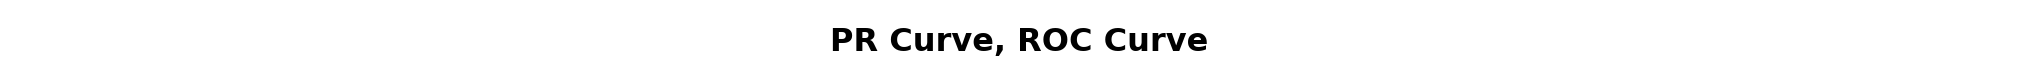

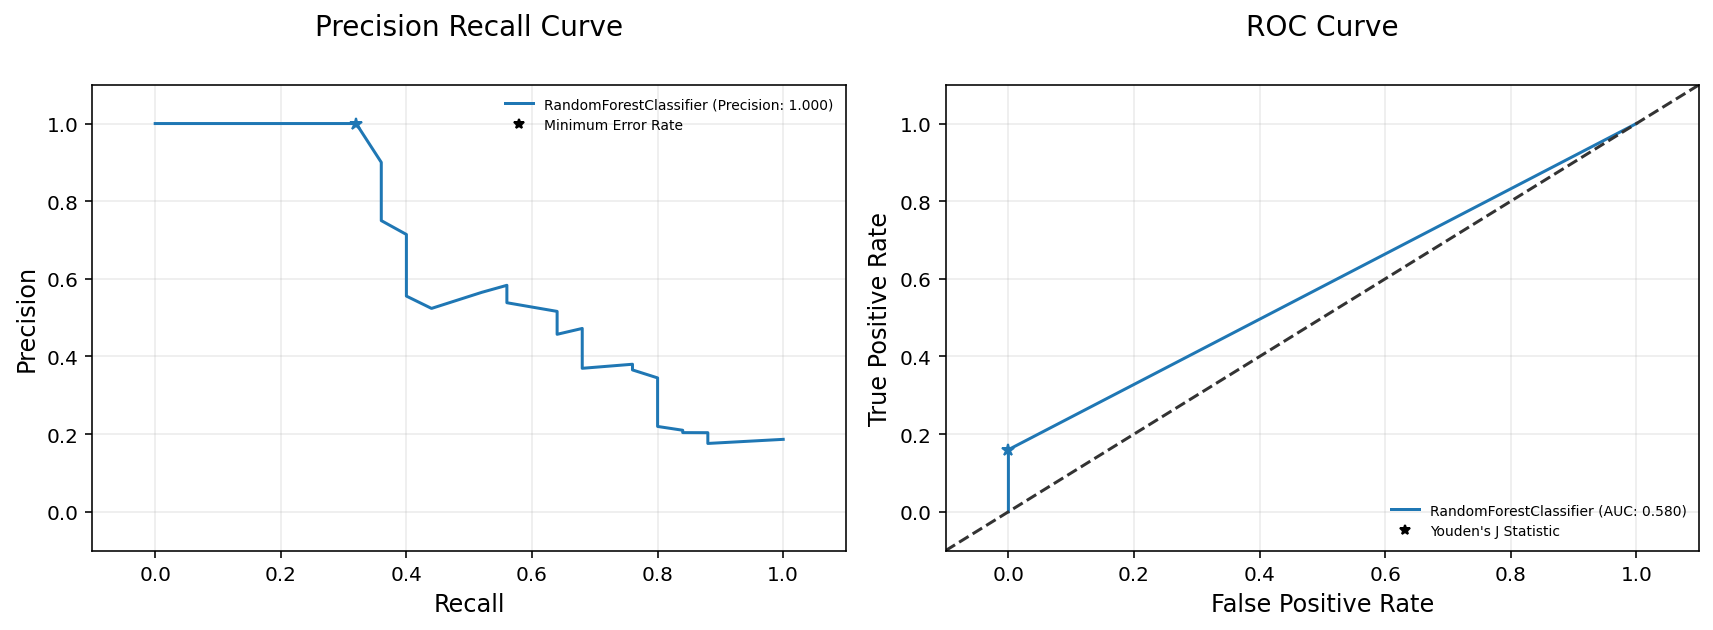

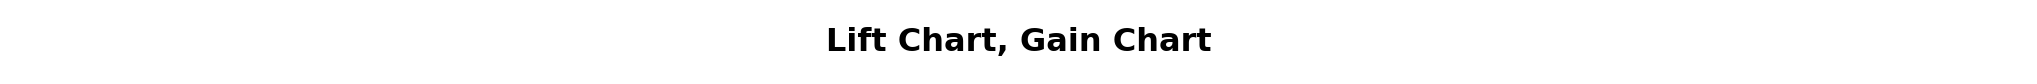

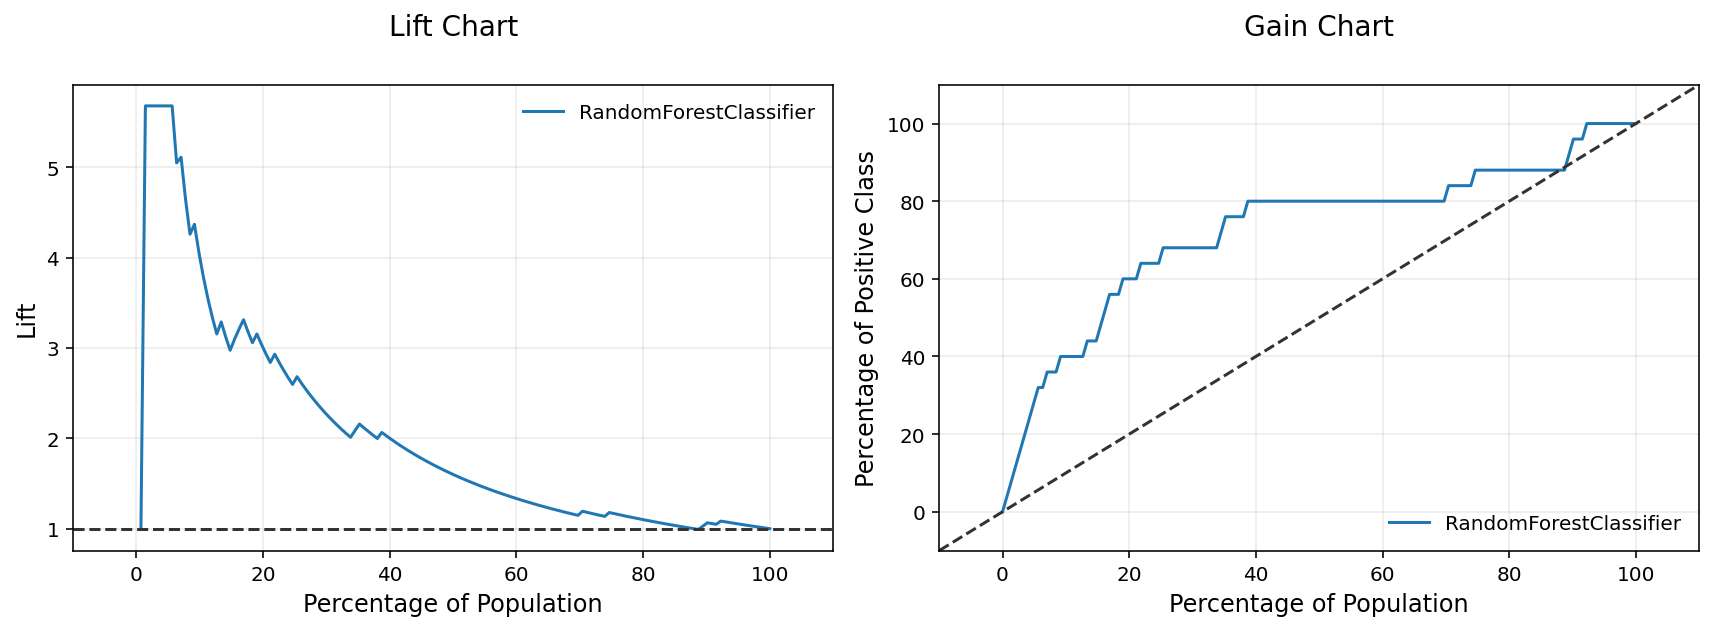

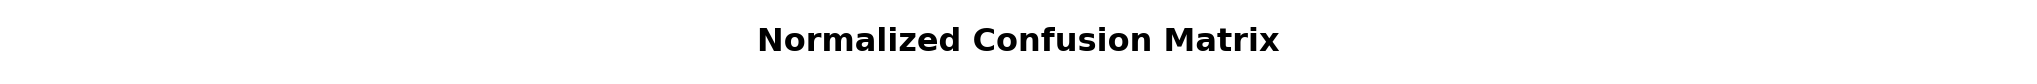

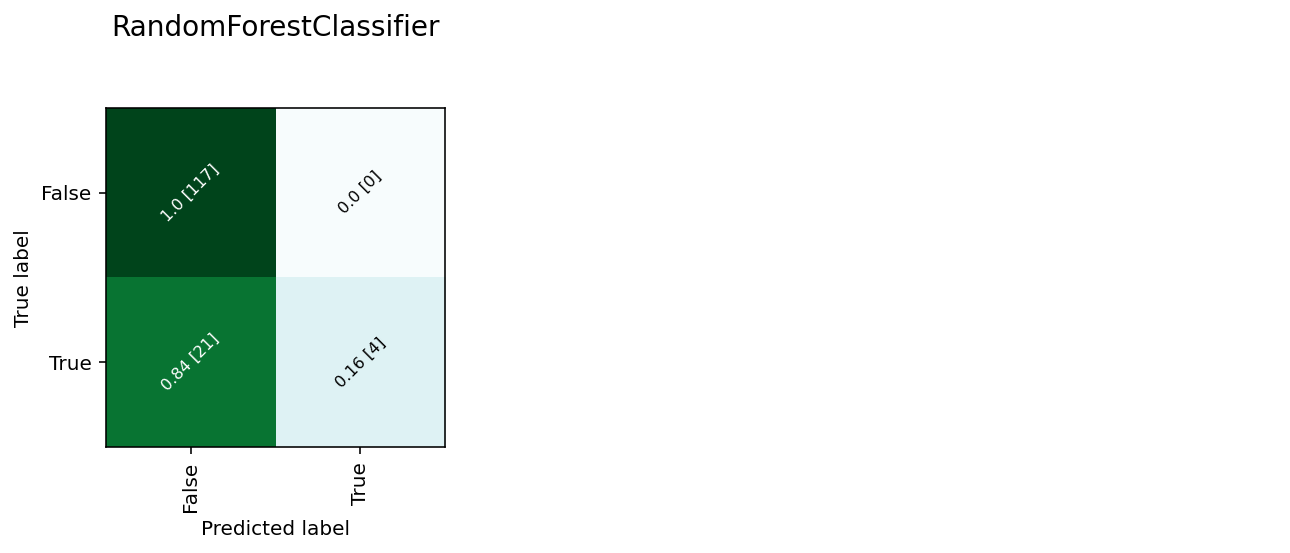

In [11]:
evaluator = ADSEvaluator(test, models=[my_model], 
                         training_data=train)
evaluator.show_in_notebook()

There are a number of common metrics that are used to assess the quality of a model. `ADS` provides a convenient method to compare the models and highlights the model with the highest score in each metric.

In [12]:
evaluator.metrics

HTML(value='<style type="text/css">\n#T_02b77_row0_col0, #T_02b77_row1_col0, #T_02b77_row2_col0, #T_02b77_row3…

HTML(value='<style type="text/css">\n#T_7bad2_row0_col0, #T_7bad2_row1_col0, #T_7bad2_row2_col0, #T_7bad2_row3…

A binary classification model can have one of four outcomes for each prediction. A true-negative is an outcome where the model correctly predicts the negative case, and a false-negative is an outcome where when the model incorrectly predicts the negative case. A false-positive is when the model incorrectly predicts the positive case, and a true-positive is when the model correctly predicts the positive case. However, not all false-positive and false-negatives have the same importance. For example, a cancer test has a higher cost when it incorrectly says that a patient does not have cancer when they do. The `calculate_cost` method allows the cost to be computed for each model based on the cost of each class of prediction.

In [13]:
evaluator.calculate_cost(tn_weight=1, fp_weight=3, fn_weight=2, tp_weight=2)

,model,cost
0,RandomForestClassifier,167


<a id='save'></a>
# Saving the model to the model catalog 

Now, we can save the simple random forest model in the model catalog, using the very flexible `prepare_generic_model()` function to save my model. That function creates an editable template artifact. The function `prepare_generic_model()` can support **any** model and **should always be the preferred way to save models from open source libraries**. 

`prepare_generic_model()` gives you complete control on the structure of the artifact and the definition fo the functions in `score.py`.

Note in the cell below that we specify an `inference_conda_env` value. This parameter corresponds to the conda environment we want to use for model deployment. A reference of that environment is written to `runtime.yaml` when you run `prepare_generic_model()`. The path represents where the conda environment is stored in object storage. You can find that information in the Environment Explorer. 

In [14]:
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import joblib 
import os

# Path to artifact directory for my sklearn model: 
model_artifact_location = os.path.expanduser('./model-artifact/')
os.makedirs(model_artifact_location, exist_ok=True)

# Creating a joblib pickle object of my random forest model: 
joblib.dump(sk_model, os.path.join(model_artifact_location, "model.joblib"))

# Creating the artifact template files in the directory: 
sklearn_artifact = prepare_generic_model(model_artifact_location, 
                                         inference_conda_env="oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow 2.7 for CPU on Python 3.7/1.0/tensorflow27_p37_cpu_v1",
                                         force_overwrite=True,
                                         model='model.joblib',
                                         use_case_type='BINARY_CLASSIFICATION',
                                         X_sample=train.X,
                                         y_sample=train.y)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

The conda env info is oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/TensorFlow 2.7 for CPU on Python 3.7/1.0/tensorflow27_p37_cpu_v1 and None


Next, we copy the `dataframelabelencoder.py` module in the model artifact directory. The serialized pipeline object will require the module to be defined and available when you de-serialize and load the pipeline object to memory.  

We also tweak the `score.py` template that `prepare_generic_model()` created, ensuring that `load_model()` reads in the `model.joblib` file.

In [15]:
#setting paths for artifact files that need to be modified: 

encoder_path = os.path.join(model_artifact_location, "dataframelabelencoder.py")
score_path = os.path.join(model_artifact_location, "score.py")
!cp dataframelabelencoder.py {encoder_path}

In [16]:
%%writefile {score_path}

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""

import json
import os
from joblib import load
import io 
import pandas as pd
import logging 

# logging configuration - OPTIONAL 
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('input-features')
logger_feat.setLevel(logging.INFO)

from dataframelabelencoder import DataFrameLabelEncoder

def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = "model.joblib"
    # TODO: Load the model from the model_dir using the appropriate loader
    # Below is a sample code to load a model file using `cloudpickle` which was serialized using `cloudpickle`
    # from cloudpickle import cloudpickle
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = load(file) # Use the loader corresponding to your model file.
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    assert model is not None, "Model is not loaded"
    X = pd.read_json(io.StringIO(data)) if isinstance(data, str) else pd.DataFrame.from_dict(data)
    preds = model.predict(X).tolist()
#    logger_pred.info(preds)
#    logger_feat.info(X)    
    return { 'prediction': preds }

Overwriting ./model-artifact/score.py


### Testing the artifact before saving to the catalog

It is always a good idea to test your model artifact before saving it to the catalog. Here we load the `score.py` module along with `load_model` and `predict`. We test predict by passing the training dataframe, doing the same for the predict() method of the sklearn model object. Next, we compare the two prediction arrays. These two should be identical.

In [17]:
input_data = train.X[:5]

In [18]:
import sys 

# add the path of score.py: 
sys.path.insert(0, model_artifact_location)

from score import load_model, predict

# Load the model to memory 
_ = load_model()
# make predictions on the first five rows of the training dataset: 
predictions = predict(input_data.to_json()) 

# The two lists should match:
print(f"* * * score.predict() and the pipeline predict() return the same predictions \
on the same data: {sk_model.predict(input_data).tolist() == predictions['prediction']}")

* * * score.predict() and the pipeline predict() return the same predictions on the same data: True


## Saving the Model to the Model Catalog

In [19]:
mc_model = sklearn_artifact.save(project_id=os.environ['PROJECT_OCID'], 
                               compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'], 
                               #training_id=os.environ['ocid1.datasciencenotebooksession.oc1.iad.amaaaaaav66vvnial3nkebuity2wq46szqsjqbo3s6b5l76qycuufkpuplca'],
                               display_name="attrition-model",
                               ignore_introspection=False,
                               description="simple sklearn model to predict employee attrition", 
                               training_script_path="1-model-training.ipynb", 
                               ignore_pending_changes=True)

INFO:ads.common:{
  "git_branch": "None",
  "git_commit": "None",
  "repository_url": "None",
  "script_dir": "/home/datascience/model-artifact",
  "training_id": null,
  "training_script": "None"
}
['score.py', 'dataframelabelencoder.py', 'model.joblib', 'input_schema.json', 'test_json_output.json', 'runtime.yaml', 'output_schema.json']
ERROR:ads.common:Model introspection not passed. See the table below for more detailed information and follow the messages to fix it, otherwise you might come across errors during model deployment. To save model artifacts ignoring introspection use .save(ignore_introspection=True...).


,Test key,Test name,Result,Message
0,runtime_env_path,Check that field MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is set,Passed,
1,runtime_env_python,Check that field MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION is set to a value of 3.6 or higher,Failed,"In runtime.yaml, the key MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION must be set to a value of 3.6 or higher."
2,runtime_env_slug,Check that field MODEL_DEPLOYMENT.INFERENCE_ENV_SLUG is set,Passed,
3,runtime_env_type,"Check that field MODEL_DEPLOYMENT.INFERENCE_ENV_TYPE is set to a value in (published, data_science)",Passed,
4,runtime_path_exist,"If MODEL_DEPLOYMENT.INFERENCE_ENV_TYPE is data_science and MODEL_DEPLOYMENT.INFERENCE_ENV_SLUG is set, check that the file path in MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is correct.",Skipped,
5,runtime_slug_exist,"If MODEL_DEPLOYMENT.INFERENCE_ENV_TYPE is data_science, check that the slug listed in MODEL_DEPLOYMENT.INFERENCE_ENV_SLUG exists.",Skipped,
6,runtime_version,Check that field MODEL_ARTIFACT_VERSION is set to 3.0,Passed,
7,runtime_yaml,"Check that the file ""runtime.yaml"" exists and is in the top level directory of the artifact directory",Passed,
8,score_load_model,Check that load_model() is defined,Passed,
9,score_predict,Check that predict() is defined,Passed,


ERROR:ads:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/tensorflow27_p37_cpu_v1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-9b7e3b189660>", line 8, in <module>
    ignore_pending_changes=True)
  File "/home/datascience/conda/tensorflow27_p37_cpu_v1/lib/python3.7/site-packages/ads/common/model_artifact.py", line 850, in save
    raise (IntrospectionNotPassed())
ads.common.model_introspect.IntrospectionNotPassed: Introspection not passed.


IntrospectionNotPassed: Introspection not passed.

This this the model OCID of the newly created model: 

In [ ]:
print(mc_model.id)

In [ ]:
import os
import requests
import oci
from oci.signer import Signer

from ads.model.deployment import ModelDeployer, ModelDeploymentProperties

In [ ]:
# Using Resource Principals for authn/authz : 

import ads 
ads.set_auth(auth='resource_principal')

## Deploy your Model with ADS

In the cell below, you specify the project OCID and the compartment OCID in which the model deployment resource will be created: 

In [ ]:
project_id = os.environ['PROJECT_OCID']
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']

Paste the model OCID of the model you want to deploy in the cell below. If you ran the notebook `1-model-training.ipynb`, copy the model OCID that is printed at the end of the notebook. Or copy the model OCID from the OCI console directly. 

In [ ]:
your_model_ocid = ''

Next we create a `deployment` instance by calling ADS `ModelDeployer()` and create a deployment. **The cell below takes a few minutes to complete**. ADS will give you a progress bar to track the progress of your deployment. You can also keep track of the deployment in the OCI console directly. Once the model deployment is ready, ADS will tell you that the deployment is in an "ACTIVE" state. The progress bar will be red and marked as "DONE".  

We are using a simple deployment configuration with a single VM.Standard2.1 shape. Feel free to change the shape size or the instance count. More details about the various options that are available (including changing the load balancer badwidth size) can be found [here](https://docs.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/model_deployment/model_deployment.html). 

In [ ]:
deployer = ModelDeployer()

deployment = deployer.deploy(
    model_id=your_model_ocid,
    display_name="Attrition Prediction Deployment",
    instance_shape="VM.Standard2.1",
    instance_count=1,
    project_id=project_id,
    compartment_id=compartment_id
)

deployment_id = deployment.model_deployment_id
print(f"Deployment {deployment_id} is {deployment.state.name}")

# Invoke the Model HTTP Endpoint with OCI Python SDK and ADS 

Once a model is successfully deployed, the next step is to invoke the model `/predict` endpoint. 

In the cell below, we define a JSON payload that we pass to the model endpoint. This payload corresponds to the first five rows of the training dataset defined in notebook `1-model-training.ipynb`. 

In [ ]:
input_data='{"Age":{"0":42,"1":50,"2":38,"3":34,"5":33},"TravelForWork":{"0":"infrequent","1":"often","2":"infrequent","3":"often","5":"often"},"SalaryLevel":{"0":5054,"1":1278,"2":6296,"3":6384,"5":4608},"JobFunction":{"0":"Product Management","1":"Software Developer","2":"Software Developer","3":"Software Developer","5":"Software Developer"},"CommuteLength":{"0":2,"1":9,"2":3,"3":4,"5":3},"EducationalLevel":{"0":"L2","1":"L1","2":"L2","3":"L4","5":"L2"},"EducationField":{"0":"Life Sciences","1":"Life Sciences","2":"Other","3":"Life Sciences","5":"Life Sciences"},"EnvironmentSatisfaction":{"0":2,"1":3,"2":4,"3":4,"5":4},"Gender":{"0":"Female","1":"Male","2":"Male","3":"Female","5":"Male"},"HourlyRate":{"0":94,"1":61,"2":92,"3":56,"5":79},"JobInvolvement":{"0":3,"1":2,"2":2,"3":3,"5":3},"JobRole":{"0":"Sales Executive","1":"Research Scientist","2":"Laboratory Technician","3":"Research Scientist","5":"Laboratory Technician"},"JobSatisfaction":{"0":4,"1":2,"2":3,"3":3,"5":4},"MaritalStatus":{"0":"Single","1":"Married","2":"Single","3":"Married","5":"Single"},"MonthlyRate":{"0":19479,"1":24907,"2":2396,"3":23159,"5":11864},"NumCompaniesWorked":{"0":8,"1":1,"2":6,"3":1,"5":0},"OverTime":{"0":"Yes","1":"No","2":"Yes","3":"Yes","5":"No"},"PercentSalaryHike":{"0":11,"1":23,"2":15,"3":11,"5":13},"PerformanceRating":{"0":3,"1":4,"2":3,"3":3,"5":3},"RelationshipSatisfaction":{"0":1,"1":4,"2":2,"3":3,"5":3},"StockOptionLevel":{"0":0,"1":1,"2":0,"3":0,"5":0},"YearsinIndustry":{"0":8,"1":10,"2":7,"3":8,"5":8},"TrainingTimesLastYear":{"0":0,"1":3,"2":3,"3":3,"5":2},"WorkLifeBalance":{"0":1,"1":3,"2":3,"3":3,"5":2},"YearsAtCurrentLevel":{"0":4,"1":7,"2":0,"3":7,"5":7},"YearsSinceLastPromotion":{"0":0,"1":1,"2":0,"3":3,"5":3},"name":{"0":"Tracy Moore","1":"Andrew Hoover","2":"Julie Bell","3":"Thomas Adams","5":"Rhonda Grant"}}'

## Invoking your Model with the OCI Python SDK and the `requests` Python Library

Next, **paste the model deployment uri in the cell below**. You can find the uri in the OCI console in the details page of your model deployment under "Resources > Invoking Your Model".  

This cell also lets you configuration the method of authentication you want to use with your model endpoint. Two options are available: 
* user principal (aka config + key approach) 
* resource principal 

The cell defaults to resource principal. If you prefer to use user principal, set the flag `usign_rps` to `False`. 

In [ ]:
# Using resource principals. You can alternatively use the config+key flow. 
using_rps = True
# Replace with the uri of your model deployment: 
uri = ""

if using_rps: # using resource principal:     
    auth = oci.auth.signers.get_resource_principals_signer()
else: # using config + key: 
    config = oci.config.from_file("~/.oci/config") # replace with the location of your oci config file
    auth = Signer(
        tenancy=config['tenancy'],
        user=config['user'],
        fingerprint=config['fingerprint'],
        private_key_file_location=config['key_file'],
        pass_phrase=config['pass_phrase'])

Finally we submit a request to the model endpoint using the payload defined in `input_data`. 

The model trained in notebook `1-model-training.ipynb` should return values `[True, False, True, False, False]`. 

In [ ]:
%%time 

# submit request to model endpoint: 
requests.post(uri, json=input_data, auth=auth).json()

## Invoking with `ADS`

You can load pre-created model deployments in ADS using the `get_model_deployment()` method of the `ModelDeployer` object. Simply pass the OCID of the model deployment you want to invoke. 

In [ ]:
deployer = ModelDeployer()
# Replace with your model deployment OCID value: 
model_deployment_ocid = ""
deployment = deployer.get_model_deployment(model_deployment_ocid)

In [ ]:
deployment.properties

In [ ]:
%%time 
deployment.predict(input_data)

ADS also has a bunch of useful methods to make it easy for you to interact with your model deployment. The `logs` feature is quite useful to access your predict and access logs if you configured them. For example: 

In [ ]:
#deployment.show_logs(log_type="access", limit=10)
# or as a dataframe: 
#predict_logs = deployment.logs(log_type="predict", limit=3)

#For more, see: https://docs.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/model_deployment/logs.html